In [110]:
import numpy as np
import tensorflow.compat.v1 as tf
from math import sqrt
import matplotlib.pyplot as plt



def sample_jester_data(file_name, context_dim = 32, num_actions = 8, num_contexts = 19181, \
                       shuffle_rows=True, shuffle_cols=False):
    """Samples bandit game from (user, joke) dense subset of Jester dataset. 
    Args:
        file_name: Route of file containing the modified Jester dataset. 
        context_dim: Context dimension (i.e. vector with some ratings from a user). 
        num_actions: Number of actions (number of joke ratings to predict). 
        num_contexts: Number of contexts to sample.
        shuffle_rows: If True, rows from original dataset are shuffled. 
        shuffle_cols: Whether or not context/action jokes are randomly shuffled.
    Returns:
        dataset: Sampled matrix with rows: (context, rating_1, ..., rating_k). 
        opt_vals: Vector of deterministic optimal (reward, action) for each context.
    """
    np.random.seed(0)
    with tf.gfile.Open(file_name, 'rb') as f:
        dataset = np.load(f)
        
    if shuffle_cols:
        dataset = dataset[:, np.random.permutation(dataset.shape[1])]
    if shuffle_rows: 
        np.random.shuffle(dataset)
    dataset = dataset[:num_contexts, :]
        
    assert context_dim + num_actions == dataset.shape[1], 'Wrong data dimensions.'
    
    opt_actions = np.argmax(dataset[:, context_dim:], axis=1)
    opt_rewards = np.array([dataset[i, context_dim + a] for i, a in enumerate(opt_actions)]) 
    return dataset, opt_rewards, opt_actions

In [121]:
class linUCB:

    def __init__(self, n_context, n_action, alpha):
        
        self.n_action = n_action
        self.n_context = n_context
        # D'D + I, dimension n_action by n_context by n_context
        self.A_inv = [np.identity(n_context) for _ in range(n_action)]
        
        #D'r dimenion n_action by n_context by 1
        self.b = np.zeros((n_action, n_context, 1))
        
        self.theta = np.zeros((n_action, n_context, 1))
        
        self.alpha = alpha
    
    def oneStepTraining(self, x, reward):
        #calculate the upper ci based on the context
        upper_vector = np.zeros(self.n_action)
        
        for a in range(self.n_action):
            a_ci_half = self.alpha * sqrt(x.dot(self.A_inv[a]).dot(x))
            a_mean = np.dot(np.squeeze(self.theta[a]), x)
            upper_vector[a] = a_mean + a_ci_half
        
        upper_vector += np.random.random(self.n_action)* 0.000001
        ac = upper_vector.argmax()
        re = reward[ac]
        
        #update theta
        self.A_inv[ac] -= (self.A_inv[ac].dot(np.outer(x,x)).dot(self.A_inv[ac]))/(1+x.dot(self.A_inv[ac]).dot(x))
        self.b[ac] += np.reshape(re * x, (-1,1))
        self.theta[ac] = self.A_inv[ac].dot(self.b[ac])                  
        
    def regret(self, context_test,context_reward):
        choice = np.zeros(context_test.shape[0])
        re = 0
        for ind in range(context_test.shape[0]):
            a_mean = np.zeros(self.n_action)
            for a in range(self.n_action):
                a_mean[a] = np.dot(np.squeeze(self.theta[a]), context_test[ind])
        
            a_mean += np.random.random(self.n_action)* 0.000001
            ac = a_mean.argmax()
            re += context_reward[ind][ac]
        return np.sum(context_reward.max(axis = 1)) - re
            
        
            
    

In [133]:
dataset, opt_rewards, opt_actions = sample_jester_data('jester_data_40jokes_19181users.npy')
context_train = dataset[:18000,:32]
reward_train = dataset[:18000, 32:]
context_test = dataset[18000:,:32]
reward_test= dataset[18000:, 32:]

linucb = linUCB(n_context=32, n_action=8, alpha=0.2)

regret_seq = []

for ind in range(context_train.shape[0]):
    
    linucb.oneStepTraining(context_train[ind], reward_train[ind])
    if ind % 100 == 0:
        #print(ind)
        regret_seq.append(linucb.regret(context_test, reward_test))
        


Text(0, 0.5, 'Regret')

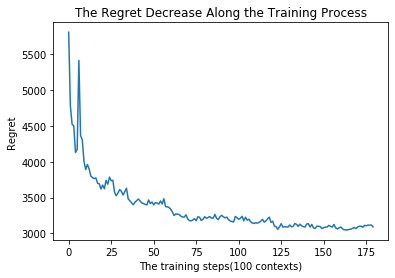

In [134]:
fig, ax = plt.subplots(1,1)
ax.plot(range(len(regret_seq)), regret_seq)
ax.set_title('The Regret Decrease Along the Training Process')
ax.set_xlabel('The training steps(100 contexts)')
ax.set_ylabel('Regret')